[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1SbDOPBlUkx2FbuuVF-s6xeTEs2jvG5n7#scrollTo=4XzVHCtt9wVf)

# **MARKET BASKET ANALYSIS ON IMBD DATASET**
## Algorithms for Massive Datasets Project

In this project we will implement A-priori and FP-growth algorithms to in order to find frequent itemsets. In this case, we used the kaggle [IMDB Dataset](https://www.kaggle.com/ashirwadsangwan/imdb-dataset), in which we considered movies as baskets and actors as items.

----

Summary:

1.   Imports
2.   Pre-Processing
3.   Market Basket Analysis









## **1. Imports**

Importing kaggle.

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"martinaviggiano","key":"53a50dae23b35b3c81b9063b6c417e93"}'}

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing imdb-dataset data.

In [5]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.44G/1.44G [00:37<00:00, 36.4MB/s]
100% 1.44G/1.44G [00:37<00:00, 40.8MB/s]


In [6]:
!unzip imdb-dataset.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


## **2. Pre-processing**

We will consider movies as baskets and actors as items.


In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import collect_set, col, count, avg
from pyspark.ml.fpm import FPGrowth
import pandas as pd
import pickle
import time
from tqdm import tqdm
import itertools
from itertools import combinations, product
import matplotlib.pyplot as plt
import collections

In [3]:
conf = SparkConf().setAppName("MBA")
spark = SparkSession.builder.enableHiveSupport().config(conf = conf).getOrCreate()
sc = spark.sparkContext

In [4]:
title_basics = spark.read.csv('title.basics.tsv.gz', header=True, sep = '\t')

In [5]:
title_basics = title_basics.filter((title_basics.titleType == 'movie'))
title_basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

We define also a smaller dataset, composed of only a 10% fraction of the original set.

In [6]:
title_basics_fraction = title_basics.sample(fraction=0.1, withReplacement=False, seed = 1)

In [7]:
title_principals = spark.read.csv('title.principals.tsv.gz', header=True, sep = '\t')

In [8]:
title_principals = title_principals.filter((title_principals.category == "actor") | (title_principals.category == "actress"))
title_principals = title_principals.select("tconst","nconst")
title_principals.show(5)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0000005|nm0443482|
|tt0000005|nm0653042|
|tt0000007|nm0179163|
|tt0000007|nm0183947|
|tt0000008|nm0653028|
+---------+---------+
only showing top 5 rows



In [9]:
df_title = title_principals.join(title_basics, ["tconst"], 'leftsemi')
df_title_fraction = title_principals.join(title_basics_fraction, ["tconst"], 'leftsemi')
df_title.show(5)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0000335|nm1010955|
|tt0000335|nm1012612|
|tt0000335|nm1011210|
|tt0000335|nm1012621|
|tt0000335|nm0675239|
+---------+---------+
only showing top 5 rows



In [16]:
# Number of rows (movies) in the entire dataset
df_title.count()

1694722

In [17]:
# Number of rows (movies) in the dataset fraction 0.1
df_title_fraction.count()

167824

In case we wanted to display the actual name of the actor/actress instead of the ID, we can run the following cells.

In [18]:
name_basics = spark.read.csv('name.basics.tsv.gz', header=True, sep = '\t')

In [19]:
name_basics = name_basics.select("nconst","primaryName")

In [20]:
df_actors_names = df_title.join(name_basics, ["nconst"], 'left')

In [21]:
df_actors_names = df_actors_names.select("tconst","primaryName")

In [22]:
baskets_names = df_actors_names.groupBy('tconst').agg(collect_set('primaryName').alias('actors'))
baskets_names.createOrReplaceTempView('baskets_')
df_actors_names.show(5)
baskets_names.show(5)

+---------+-----------------+
|   tconst|      primaryName|
+---------+-----------------+
|tt0000009|  Blanche Bayliss|
|tt0000502|      El Mochuelo|
|tt0000615|       Jim Gerald|
|tt0000679|    L. Frank Baum|
|tt0000009|William Courtenay|
+---------+-----------------+
only showing top 5 rows

+---------+--------------------+
|   tconst|              actors|
+---------+--------------------+
|tt0000335|[John Jones, Mr. ...|
|tt0000502|[Antonio del Pozo...|
|tt0000630|[Fernanda Negri P...|
|tt0000676|[Jaime Borrás, Jo...|
|tt0000793|      [Henny Porten]|
+---------+--------------------+
only showing top 5 rows



## **3. Market Basket Analysis**

We define and populate baskets: for each movie (*tconst*) we assign the list of actors (*nconst*) preforming in it.

In [10]:
# Computed on the whole df
baskets = df_title.groupBy('tconst').agg(collect_set('nconst').alias('actors'))
baskets.createOrReplaceTempView('baskets')
baskets.show(5)

+---------+--------------------+
|   tconst|              actors|
+---------+--------------------+
|tt0000335|[nm1012612, nm067...|
|tt0000630|         [nm0624446]|
|tt0000676|[nm0140054, nm009...|
|tt0000793|         [nm0691995]|
|tt0000862|[nm0264569, nm528...|
+---------+--------------------+
only showing top 5 rows



In [11]:
# Computed on 0.1 fraction
baskets_fraction = df_title_fraction.groupBy('tconst').agg(collect_set('nconst').alias('actors'))
baskets_fraction.createOrReplaceTempView('baskets_fraction')
baskets_fraction.show(5)

+---------+--------------------+
|   tconst|              actors|
+---------+--------------------+
|tt0000502|[nm0252720, nm021...|
|tt0001122|[nm0167461, nm094...|
|tt0002119|         [nm0898366]|
|tt0002602|[nm1267460, nm053...|
|tt0002648|[nm0016799, nm091...|
+---------+--------------------+
only showing top 5 rows



### **3.2 A-priori Algorithm**
We implement an A-priori Algorithm from scratch.

The function takes as input a Resilient Distributed Dataset (RDD) and a given threshold:

*   We created a list of lists composed of each itemset and we flattened it.
*   We created tuples associating to each item its frequency count.
*   We filtered the singletons based on the threshold chosen and we kept only items with frequency above the level provided.
*   We built all the possible combinations of pairs of frequent singletons retrieved in the previous step: we checked if each pair we retrieved were present in out set of baskets and then we filtered again for the threshold.
*   We repeated the steps above to search for frequent triplets, starting from the results we obtained previously.

At the end of the process we obtained a list of tuples of frequent itemsets and the corresponding frequency.

First of all, we create a Resilient Distributed Dataset RDD, which corresponds to the list of baskets of actors.

In [25]:
# Computed on the whole dataset
baskets_actors = baskets.select('actors').rdd.flatMap(list) 
print(baskets_actors.collect()[:3])

[['nm1012612', 'nm0675260', 'nm1012621', 'nm1010955', 'nm0675239', 'nm1011210'], ['nm0624446'], ['nm0140054', 'nm0097421']]


In [26]:
baskets_actors.getNumPartitions() 

4

In [27]:
# Computed on the fraction 0.1
baskets_actors_fraction = baskets_fraction.select('actors').rdd.flatMap(list) 
print(baskets_actors_fraction.collect()[:3])

[['nm0252720', 'nm0215752'], ['nm0167461', 'nm0941542', 'nm0756543', 'nm0154988'], ['nm0898366']]


In [28]:
baskets_actors_fraction.getNumPartitions() 

2

 We first define a function listing all the actors/actresses present in dataset and counting occurrences.

In [29]:
def count_singletons(data): 
  list_singletons = data.flatMap(list).map(lambda actor: (actor, 1)).reduceByKey(lambda a, b: a+b)
  return(list_singletons)

We display the top 10 actors present in our dataset with respect to the occurrencies.

In [30]:
freq_actors = count_singletons(baskets_actors).sortBy(lambda a: -a[1])
freq_actors.take(10)

[('nm0103977', 797),
 ('nm0006982', 585),
 ('nm0648803', 565),
 ('nm0305182', 506),
 ('nm0623427', 436),
 ('nm0793813', 411),
 ('nm0246703', 391),
 ('nm0619107', 387),
 ('nm0007123', 380),
 ('nm7390393', 356)]

We then define a function filtering out singletons (actors) not compliant with the threshold we chose.

In [31]:
def actors_threshold(baskets, threshold, remove=True):
    actors_selected = count_singletons(baskets).filter(lambda freq: freq[-1] >= threshold)
    if remove:
        actors_selected = actors_selected.map(lambda a: (a[:-1]))
    return (actors_selected)

In [32]:
# Testing 
t1 = actors_threshold(baskets_actors, 118)

In [33]:
t1.take(2)

[('nm0435229',), ('nm0002503',)]

We define a function which performs the computations of both the functions above: *count_singletons* and *actors_threshold*.

In [34]:
def singleton_threshold(data, threshold):
    list_singletons = data.flatMap(list).map(lambda actor: (actor, 1)).reduceByKey(lambda a, b: a+b)
    actors_counts = list_singletons.filter(lambda freq: freq[1] >= threshold)
    actors_selected = actors_counts.map(lambda a: (a[0]))
    return(actors_selected)

In [35]:
# Testing
t2 = singleton_threshold(baskets_actors, 118)

In [36]:
t2.take(2)

['nm0435229', 'nm0002503']

We set the threshold we will use in the Apriori algorithm.

In [37]:
count_fraction = baskets_actors_fraction.count()
threshold_fraction = count_fraction*0.0003
print(count_fraction, threshold_fraction)

38991 11.697299999999998


In [38]:
count = baskets_actors.count()
threshold = count*0.0003
print(count, threshold)

393759 118.12769999999999


We define the Apriori algorithm.

In [39]:
def Apriori(baskets, threshold):

    # SINGLETONS
    # retrieve list of singletons (actors) with frequence above the threshold in data
    singletons = singleton_threshold(baskets, threshold)

    # PAIRS
    # compute all possible combinations of 2 elements (pairs) from le list of frequent items "singletons"
    comb_actors = list(combinations(singletons.toLocalIterator(), 2))
    # create empty list
    selected = sc.parallelize([]) 
    # select only frequent pairs, i.e. with frequence above the threshold
    frequent_items_1 = baskets.flatMap(lambda basket: [(tuple(item), 1) for item in comb_actors if set(list(item)).issubset(set(basket))]).reduceByKey(lambda a, b: a+b).filter(lambda freq: freq[1] >= threshold)
    # populate the list with frequent pairs   
    selected = selected.union(frequent_items_1) 

    # TRIPLETS
    # pre-process sets
    pairs = frequent_items_1.map(lambda item: list(item[0]))
    sin = count_singletons(singletons).map(lambda item: [item[0]])
    # create empty list for new combinations
    comb_actors = [] 
    # build combinations of three elements (triplets) between the pairs filtered for threshold and singletons filtered for threshold
    for x in list(product(pairs.toLocalIterator(), sin.toLocalIterator())): 
        combination = x[0]+x[1] 
        comb_actors.append(combination)
    # select only frequent triplets, i.e. with frequence above the threshold
    frequent_items_2 = baskets.flatMap(lambda basket: [(tuple(item), 1) for item in comb_actors if set(list(item)).issubset(set(basket))]).reduceByKey(lambda a, b: a+b).filter(lambda freq: freq[1] >= threshold)
    # populate the list with frequent triplets     
    selected = selected.union(frequent_items_2) 

    return(selected)

We train model on the fraction of the dataset.

In [ ]:
start_time = time.time()
priori_frac_0003 = Apriori(baskets_actors_fraction, threshold_fraction).collect()
print(time.time() - start_time)
time_frac_0003 = time.time() - start_time

3052.6985170841217


We display the results of the three models below.

In [ ]:
priori_frac_0003

[(('nm0006982', 'nm0623427'), 21),
 (('nm0006982', 'nm0046850'), 13),
 (('nm0006982', 'nm0419653'), 12),
 (('nm2077739', 'nm2082516'), 13),
 (('nm0648803', 'nm2373718'), 12),
 (('nm0477107', 'nm0158656'), 13),
 (('nm0246703', 'nm0688093'), 13),
 (('nm2366585', 'nm1698868'), 13),
 (('nm2077739', 'nm0648803'), 14),
 (('nm2077739', 'nm2373718'), 13),
 (('nm2082516', 'nm0648803'), 14),
 (('nm2082516', 'nm2373718'), 12)]

In [ ]:
priori_frac_0004

[(('nm0623427', 'nm0006982'), 23),
 (('nm0006982', 'nm0419653'), 27),
 (('nm0006982', 'nm0046850'), 21),
 (('nm0006982', 'nm0080246'), 17),
 (('nm0419653', 'nm0046850'), 19),
 (('nm2082516', 'nm0648803'), 16)]

In [ ]:
priori_frac_0005

[(('nm0623427', 'nm0006982'), 23),
 (('nm0006982', 'nm0419653'), 27),
 (('nm0006982', 'nm0046850'), 21)]

In [ ]:
time = [4675, 1083, 731]
support = ['0.0003', '0.0004', '0.0005']
d = {'Support':support, 'Seconds':time}
df_models_frac = pd.DataFrame(d)
df_models_frac

,Support,Seconds
0,0.0003,4675
1,0.0004,1083
2,0.0005,731


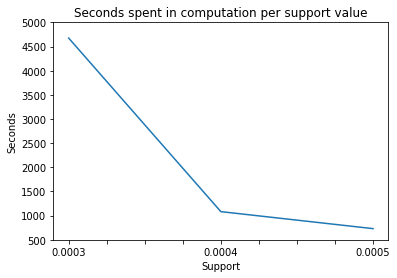

In [ ]:
plot_time_frac = df_models_frac.plot(x="Support", y="Seconds", ylabel='Seconds', legend=False, title='Seconds spent in computation per support value', ylim=(500,5000), rot=0)

In [ ]:
df_priori_frac_0003 = pd.DataFrame(priori_frac_0003, columns=['Actors', 'Frequency'])
df_priori_frac_0004 = pd.DataFrame(priori_frac_0004, columns=['Actors', 'Frequency'])
df_priori_frac_0005 = pd.DataFrame(priori_frac_0005, columns=['Actors', 'Frequency'])

---

In [26]:
start_time = time.time()
priori_0003 = Apriori(baskets_actors, threshold).collect() # 0.0003 20 min
print(time.time() - start_time)
time_0003 = time.time() - start_time

23251.222039461136


We display the results of the three models below.

In [27]:
priori_0003

[(('nm0006982', 'nm0623427'), 236),
 (('nm0006982', 'nm0419653'), 162),
 (('nm0006982', 'nm0046850'), 169),
 (('nm0648803', 'nm2373718'), 126),
 (('nm0006982', 'nm0619779'), 122),
 (('nm2082516', 'nm0648803'), 147)]

In [ ]:
priori_0004

[(('nm0006982', 'nm0623427'), 236),
 (('nm0006982', 'nm0419653'), 162),
 (('nm0006982', 'nm0046850'), 169)]

In [ ]:
priori_0005

[(('nm0006982', 'nm0623427'), 236)]

In [41]:
priori_0003

[(('nm0006982', 'nm0623427'), 236),
 (('nm0006982', 'nm0419653'), 162),
 (('nm0006982', 'nm0046850'), 169),
 (('nm0648803', 'nm2373718'), 126),
 (('nm0006982', 'nm0619779'), 122),
 (('nm2082516', 'nm0648803'), 147)]

In [43]:
time = [23251, 4317, 1198]
support = ['0.0003', '0.0004', '0.0005']
d_ = {'Support':support, 'Seconds':time}
df_models = pd.DataFrame(d_)
df_models

,Support,Seconds
0,0.0003,23251
1,0.0004,4317
2,0.0005,1198


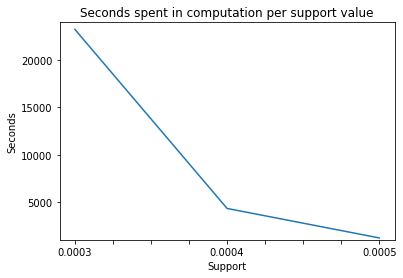

In [44]:
plot_time = df_models.plot(x="Support", y="Seconds", ylabel='Seconds', legend=False, title='Seconds spent in computation per support value', ylim=(1000,24000), rot=0)

In [49]:
df_priori_0003 = pd.DataFrame(priori_0003, columns=['Actors', 'Frequency'])
df_priori_0004 = pd.DataFrame(priori_0004, columns=['Actors', 'Frequency'])
df_priori_0005 = pd.DataFrame(priori_0005, columns=['Actors', 'Frequency'])

---

### **3.1 FP-Growth**
In this section we will implement the FP-Growth algorithm by using the *FPGrowth* function of Spark.

We first display the relation between speed of the computation and the size of the dataset. To do so, we create 5 small samples of the baskets.

In [12]:
subset25 = baskets.sample(fraction=0.25, withReplacement=False, seed = 1)
subset20 = baskets.sample(fraction=0.2, withReplacement=False, seed = 1)
subset15 = baskets.sample(fraction=0.15, withReplacement=False, seed = 1)
subset10 = baskets.sample(fraction=0.1, withReplacement=False, seed = 1)
subset05 = baskets.sample(fraction=0.05, withReplacement=False, seed = 1)

In [13]:
seconds = []
size = []
subsets = [subset25, subset20,  subset15, subset10, subset05]
fpGrowth = FPGrowth(itemsCol="actors", minSupport=0.00003)

for sub in tqdm(subsets):
    c = sub.count()
    size.append(c)
    start_time = time.time()
    model_ = fpGrowth.fit(sub)
    seconds.append(time.time() - start_time)

100%|██████████| 5/5 [19:16<00:00, 231.37s/it]


In [30]:
size_time = {'Size':size, 'Seconds':seconds}
df_size_time = pd.DataFrame(size_time)
df_size_time

,Size,Seconds
0,98103,164.861204
1,78668,165.803203
2,58925,165.180027
3,39346,151.287328
4,19719,132.911478


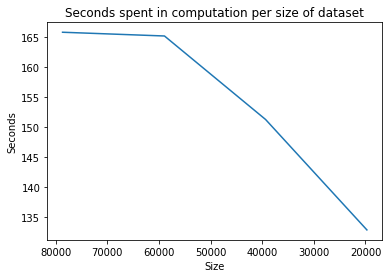

In [33]:
plot_size_time = df_size_time.plot(x="Size", y="Seconds", ylabel='Seconds',legend=False, title='Seconds spent in computation per size of dataset')
plot_size_time.invert_xaxis()

Then, we run the algorithm using different values of support to see the differences in terms of time spent in computation and number of association rule found by the algorithm.

In [35]:
seconds = []
n_rules = []
supports = [0.00001, 0.00002, 0.00003, 0.00004, 0.0001]

for sup in tqdm(supports):
    fpGrowth = FPGrowth(itemsCol="actors", minSupport=sup)
    start_time = time.time()
    model_ = fpGrowth.fit(baskets)
    seconds.append([sup, time.time() - start_time])
    associationRules_ = model_.associationRules
    rules = associationRules_.count()
    n_rules.append([sup, rules])

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
100%|██████████| 5/5 [12:29<00:00, 149.86s/it]


We plot the relation between value of support and time spent in computing.

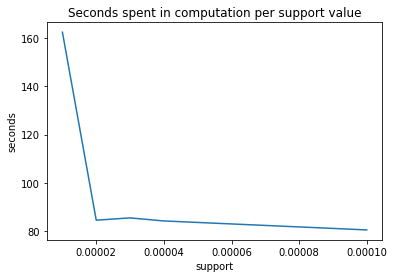

In [36]:
df_results = pd.DataFrame(seconds, columns=["support", "seconds"])
plot_time = df_results.plot(x="support", y="seconds", ylabel='seconds',legend=False, title='Seconds spent in computation per support value')
df_results.to_csv("time_results_fpgrowth.csv", index=False)

In [38]:
df_results # new one

,support,seconds
0,0.00001,162.405219
1,0.00002,84.468381
2,0.00003,85.416770
3,0.00004,84.149662
4,0.00010,80.431349


In [63]:
df_results

,support,seconds
0,0.00001,152.615942
1,0.00002,88.091414
2,0.00003,86.691423
3,0.00004,83.764134
4,0.00010,86.327556


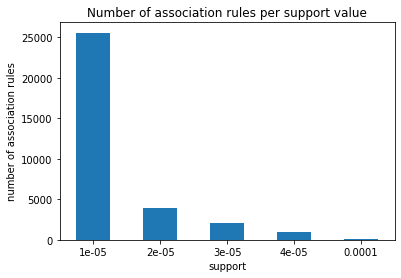

In [65]:
df_nrules = pd.DataFrame(n_rules, columns=["support", "n_rules"])
plot_nrules = df_nrules.plot.bar(x="support", y="n_rules", ylabel='number of association rules', legend=False, title='Number of association rules per support value', rot=0)
df_nrules.to_csv("nrules_results_fpgrowth.csv", index=False)

In [67]:
df_nrules

,support,n_rules
0,0.000,25583
1,0.000,3893
2,0.000,2051
3,0.000,940
4,0.0001,120


In the following part we selected support value 0.00001 and we display the results of the model.

In [69]:
fpGrowth = FPGrowth(itemsCol="actors", minSupport=0.00001)
model = fpGrowth.fit(baskets)

We Display association rules generated by the model computed setting the support equal to 0.00001

In [70]:
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+-----------+------------------+------------------+--------------------+
|          antecedent| consequent|        confidence|              lift|             support|
+--------------------+-----------+------------------+------------------+--------------------+
|         [nm3721804]|[nm1990182]|               0.8|3841.5512195121955|1.015849796449097E-5|
|         [nm3721804]|[nm1984183]|               1.0|2250.0514285714285|1.269812245561371...|
|[nm0623325, nm381...|[nm0706691]|0.8571428571428571|1071.4530612244896|1.523774694673645...|
|[nm2719915, nm128...|[nm1770187]|0.8571428571428571|2836.1992797118846|1.523774694673645...|
|[nm2719915, nm128...|[nm2077739]|0.8571428571428571|2884.6813186813188|1.523774694673645...|
|[nm2719915, nm128...|[nm0648803]|               1.0| 696.9185840707964| 1.77773714378592E-5|
|[nm1371510, nm075...|[nm1285427]|               0.8|3461.6175824175825|1.015849796449097E-5|
|[nm0931054, nm041...|[nm0001889]|               0.8|       